In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVR
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib
%matplotlib inline

### TWO
- Run the label of Cumulative cases on ON and QC province
- Update the metric of top 5 pandemic hub of the evaluation acc
- Get the avg ACC score on ON and QC province of the label of Cumulative cases

## Connect to DB

In [3]:
## Run
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
new = df_COVID['HR_UID'].str.split(".", n = 1, expand = True) 
df_COVID['HR_UID']= new[0]
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
# mob_health date '2020-07-05'
max_date = mob_health['DATE'].max()
max_date1 = df_COVID['report_date'].max()
if max_date<max_date1:
    max_dt = max_date
else:
    max_dt= max_date1
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_dt)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
# add label to df
df_risk_label = pd.read_sql_query("SELECT * from HIGH_RISK_6", conn)
df_risk_label_la = df_risk_label.rename(columns={"cases": "cases_la", "cumulative_cases": "cumulative_cases_la",
                             "deaths":"deaths_la", "cumulative_deaths":"cumulative_deaths_la"})
pd_merge_label = pd.merge(pd_merge_new, df_risk_label_la, on=['report_date', 'HR_UID'], how='left')
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
#     lst.remove(label)
    data = pd_merge_label[lst]

    df_label = pd_merge_label[[label]]
    data_scale = scaler.fit_transform(data)
#     data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
#     df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_label.columns.tolist()) - set(df_data_scale.columns.tolist())- set(df_label.columns.tolist()))
    col_lst.append('PRUID_x')
    pd_feature = pd_merge_label[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, df_label], axis=1)
    return df_merge_model

# Change the label cumulative_cases_la
df_merge_model = label('cumulative_deaths_la')
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index  Perceived_health_good                    HR_NAME  \
0      0                  0.577  Peel Regional Health Unit   
1      1                  0.577  Peel Regional Health Unit   
2      2                  0.577  Peel Regional Health Unit   
3      3                  0.577  Peel Regional Health Unit   
4      4                  0.577  Peel Regional Health Unit   

   cumulative_cases_la        DATE PRUID_y report_date     PROV HR_UID  \
0                  0.0  2020-01-25      35  2020-01-25  Ontario   3553   
1                  0.0  2020-01-26      35  2020-01-26  Ontario   3553   
2                  0.0  2020-01-27      35  2020-01-27  Ontario   3553   
3                  0.0  2020-01-28      35  2020-01-28  Ontario   3553   
4                  0.0  2020-01-29      35  2020-01-29  Ontario   3553   

   Perceived_health_poor  ...      M_MP  cases  cumulative_cases deaths  \
0                  0.106  ...  0.621158    0.0               0.0    0.0   
1                  0.106  ...  0.434065    0.0               0.0    0.0   
2                  0.106  ...  0.511856    0.0               0.0    0.0   
3                  0.106  ...  0.550283    0.0               0.0    0.0   
4                  0.106  ...  0.568742    0.0               0.0    0.0   

  cumulative_deaths  Population_density  ambulatory  hospitals  \
0               0.0            0.255652         1.0   0.714286   
1               0.0            0.255652         1.0   0.714286   
2               0.0            0.255652         1.0   0.714286   
3               0.0            0.255652         1.0   0.714286   
4               0.0            0.255652         1.0   0.714286   

   nursing_residential  cumulative_deaths_la  
0                  1.0                   0.0  
1                  1.0                   0.0  
2                  1.0                   0.0  
3                  1.0                   0.0  
4                  1.0                   0.0  

[5 rows x 56 columns]

## Model Input for Multiple Input Series
-  first dimension is the number of samples
-  second dimension is the number of time steps per sample
-  the last dimension specifies the number of parallel time series or the number of variables

## Multivariate model
- label: Cum_deaths
    - lag features: 5 days
- label: Cum_cases
    - lag features: 5 days
    
- ON
    - 34 pandemic hubs
- approach
    - first
    - get independent HR df and train test split by 0.8 and 0.2, (by time-series factor), take time into account
    - concat array for X_train, and X_test

In [34]:
## Run
## change the label df_label = df_hr[['cumulative_cases_x']]
## change time_lag features
# # shift the value upward
df_merge_model['report_date'] = pd.to_datetime(df_merge_model['report_date'])
# df1 = df.set_index('DATE')
df_new = df_merge_model[['HR_UID', 'report_date','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'report_date']]

def shift_df(lst, lag_date):
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            val = -lag_date_run
            df_new[col_name] = df_new.groupby(['HR_UID'])[a].shift(val)
    return df_new

df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],5)
# remove null row
df_new1.dropna(inplace=True)
# drop duplicated columns
df_new2 = df_new1.loc[:,~df_new1.columns.duplicated()]

## Merge df back with health indicator
df_new3 = pd.merge(df_merge_model, df_new2, how='left', on=['HR_UID','report_date'])
# remove null row
df_new3.dropna(inplace=True)
# drop duplicated columns
df_new4 = df_new3.loc[:,~df_new3.columns.duplicated()]
## QC PRUID 24
df_on = df_new4.loc[df_new4['PRUID_x']==str(35)]
df_dum_HR = pd.get_dummies(df_on.HR_UID, prefix='HR_UID')
df_on_dum = pd.concat([df_on, df_dum_HR], axis=1)


# select one hr
def df_filter(hr, case, lag_date):
    df_hr = df_on_dum.loc[df_on_dum['HR_UID']==str(hr)]
    df_train = df_hr.loc[(df_hr['report_date'] >= df_hr['report_date'].min()) & (df_hr['report_date'] < '2020-07-01')]
    df_eval = df_hr.loc[(df_hr['report_date'] >= '2020-07-01') & (df_hr['report_date'] <= df_hr['report_date'].max())]
    # list for input lagged features
    lst = ['cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP']
    col_lst = []
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            col_lst.append(col_name)
            
    lst1 = ['Mt_RP_x', 'Mt_MP_x', 'Mw_MD_x', 'Mgp_RP_x', 'Population_density','ambulatory',
               'hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']
    col_lst+=lst1
    col_lst+=df_dum_HR.columns.tolist()
    
    if case:
        col_lst.append('cases_x')
    # train set
    df_feature_train = df_train[col_lst]
    df_label_train = df_train[['cumulative_deaths_la']]
    # eval set
    df_feature_val = df_eval[col_lst]
    df_label_val = df_eval[['cumulative_deaths_la']]
    # drop duplicated columns
    df_hr1 = df_hr.loc[:,~df_hr.columns.duplicated()]
   
    return df_feature_train, df_label_train, df_feature_val, df_label_val, df_hr1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [35]:
## Run
# split_sequences to change the dimensions of input
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []
X_val_lst = []
y_val_lst = []

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, label_seq):
    label_seq = label_seq.reshape(label_seq.shape[0], -1)
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], label_seq[end_ix-1, :]
#         seq_x = sequences[i:end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y).reshape(-1)

for hr in df_on['HR_UID'].unique().tolist():
    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         feature_train, label_train, test_size=0.2, random_state=42, shuffle=False)
    
    # train data
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)
    # X_train shape (124, 101)
    # val data
    Y_val = label_val.to_numpy().reshape(-1,)
    X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 2, Y_val)
    X_val_lst.append(X_val_3d)
    y_val_lst.append(y_val)
    
    
X_train = np.concatenate(X_train_lst, axis=0)
# X_train.shape (4182, 2, 101)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
# Y_train.shape (4182,)
y_test = np.concatenate(y_test_lst, axis=0)

X_val = np.concatenate(X_val_lst, axis=0)
y_val = np.concatenate(y_val_lst, axis=0)

Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
Y_val = y_val.reshape(-1,)
Y_train.shape


(2268,)

In [36]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape
# (108, 1,  11)

(2268, 1, 69)

In [7]:
def lstm(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=40, verbose=2, validation_data=(X_test, y_test))
    return history, model

In [8]:
def lstm_2layer(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features), return_sequences=True))
    model.add(LSTM(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=40, verbose=2, validation_data=(X_test, y_test))
    return history, model

## HR: Ontario Health Unit
### Label Cumulative Cases
- PRUID_x = 35

In [9]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 4284 samples, validate on 1088 samples
Epoch 1/50
 - 3s - loss: 0.2403 - accuracy: 0.9563 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 2/50
 - 1s - loss: 0.1162 - accuracy: 0.9634 - val_loss: 0.0251 - val_accuracy: 1.0000
Epoch 3/50
 - 1s - loss: 0.0943 - accuracy: 0.9634 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 4/50
 - 1s - loss: 0.0811 - accuracy: 0.9634 - val_loss: 0.0391 - val_accuracy: 1.0000
Epoch 5/50
 - 1s - loss: 0.0767 - accuracy: 0.9638 - val_loss: 0.0368 - val_accuracy: 1.0000
Epoch 6/50
 - 1s - loss: 0.0743 - accuracy: 0.9657 - val_loss: 0.0375 - val_accuracy: 1.0000
Epoch 7/50
 - 1s - loss: 0.0735 - accuracy: 0.9678 - val_loss: 0.0363 - val_accuracy: 1.0000
Epoch 8/50
 - 1s - loss: 0.0727 - accuracy: 0.9676 - val_loss: 0.0452 - val_accuracy: 1.0000
Epoch 9/50
 - 1s - loss: 0.0717 - accuracy: 0.9711 - val_loss: 0.0365 - val_accuracy: 1.0000
Epoch 10/50
 - 1s - loss: 0.0718 - accuracy: 0.9711 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 11/50
 - 1s - l

## 1 Layer LSTM model

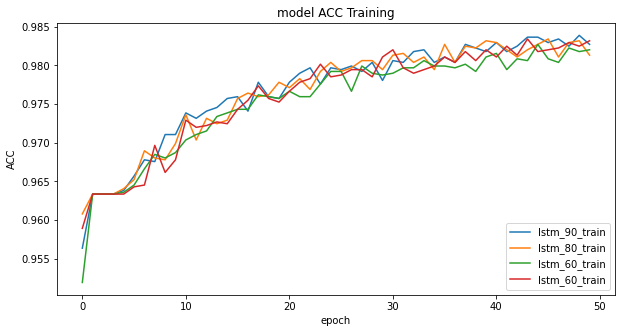

In [10]:
# with lagged 5 features

plt.figure(figsize=(10, 5))

plt.plot(history_90.history['accuracy'])
plt.plot(history_80.history['accuracy'])
plt.plot(history_60.history['accuracy'])
plt.plot(history_50.history['accuracy'])


plt.title('model ACC Training')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train', 'lstm_60_train'], loc='lower right')
plt.show()

## 2 Layer LSTM model

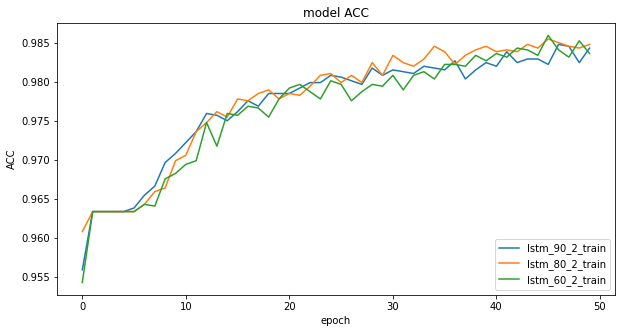

In [11]:
# with lagged 5 features

plt.figure(figsize=(10, 5))

plt.plot(history_90_2.history['accuracy'])
plt.plot(history_80_2.history['accuracy'])
plt.plot(history_60_2.history['accuracy'])

plt.title('model ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='lower right')

plt.show()

## Locate the pandemic hub (one)

In [44]:
feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter('3530', True,5)
# val data
Y_val = label_val.to_numpy().reshape(-1,)
X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 1, Y_val)

n_sample = 1
n_step = X_val_3d.shape[0]
n_features = X_val_3d.shape[-1]

prediction_90 = model_80_2.predict_classes(X_val_3d).flatten()
y_val = y_val.reshape(-1, 1)

accuracy = accuracy_score(prediction_90, y_val)

print('val acc:', accuracy)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

## Locate all pandemic hub

In [30]:
def Average(lst): 
    return sum(lst) / len(lst)

ACC_lst = []
for hr in df_on['HR_UID'].unique().tolist():
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
    # val data
    Y_val = label_val.to_numpy().reshape(-1,)
    X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 1, Y_val)

    n_sample = 1
    n_step = X_val_3d.shape[0]
    n_features = X_val_3d.shape[-1]

    prediction_90 = model_80_2.predict_classes(X_val_3d).flatten()
    y_val = y_val.reshape(-1, 1)

    accuracy = accuracy_score(prediction_90, y_val)
    ACC_lst.append(accuracy)

ON_average = Average(ACC_lst)

print('AVG ACC score ON Health Units:', ON_average)


AVG ACC score ON Health Units: 0.9934640522875817


## HR: Quebec Health Unit
### Label Cumulative Cases
- PRUID_x = 24

In [37]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 2268 samples, validate on 576 samples
Epoch 1/50
 - 2s - loss: 0.3589 - accuracy: 0.9303 - val_loss: 0.4806 - val_accuracy: 0.8333
Epoch 2/50
 - 1s - loss: 0.1409 - accuracy: 0.9519 - val_loss: 0.4118 - val_accuracy: 0.8333
Epoch 3/50
 - 1s - loss: 0.1026 - accuracy: 0.9683 - val_loss: 0.2666 - val_accuracy: 0.8889
Epoch 4/50
 - 0s - loss: 0.0839 - accuracy: 0.9753 - val_loss: 0.1997 - val_accuracy: 0.8889
Epoch 5/50
 - 1s - loss: 0.0759 - accuracy: 0.9749 - val_loss: 0.1722 - val_accuracy: 0.8889
Epoch 6/50
 - 1s - loss: 0.0720 - accuracy: 0.9766 - val_loss: 0.1499 - val_accuracy: 0.9045
Epoch 7/50
 - 1s - loss: 0.0693 - accuracy: 0.9775 - val_loss: 0.1399 - val_accuracy: 0.9236
Epoch 8/50
 - 1s - loss: 0.0677 - accuracy: 0.9749 - val_loss: 0.1696 - val_accuracy: 0.8889
Epoch 9/50
 - 1s - loss: 0.0663 - accuracy: 0.9771 - val_loss: 0.1106 - val_accuracy: 0.9444
Epoch 10/50
 - 1s - loss: 0.0662 - accuracy: 0.9757 - val_loss: 0.0975 - val_accuracy: 0.9444
Epoch 11/50
 - 1s - lo

## 1 Layer LSTM model

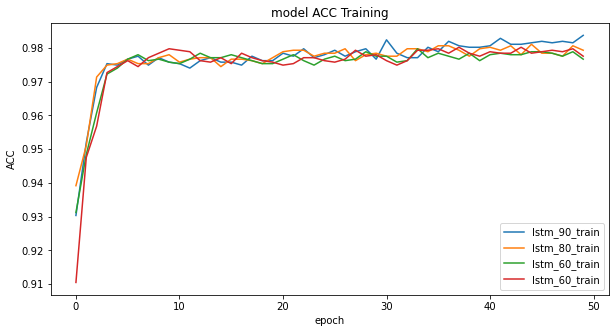

In [38]:
# with lagged 5 features

plt.figure(figsize=(10, 5))

plt.plot(history_90.history['accuracy'])
plt.plot(history_80.history['accuracy'])
plt.plot(history_60.history['accuracy'])
plt.plot(history_50.history['accuracy'])


plt.title('model ACC Training')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train', 'lstm_60_train'], loc='lower right')
plt.show()

## 2 Layer LSTM model

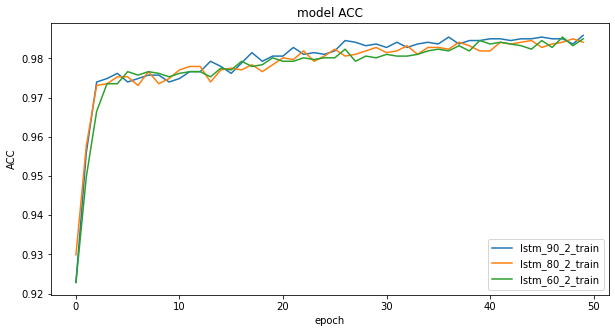

In [39]:
# with lagged 5 features

plt.figure(figsize=(10, 5))

plt.plot(history_90_2.history['accuracy'])
plt.plot(history_80_2.history['accuracy'])
plt.plot(history_60_2.history['accuracy'])

plt.title('model ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='lower right')

plt.show()

## Locate the pandemic hub (one)

In [42]:
feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter('2413', True,5)
# val data
Y_val = label_val.to_numpy().reshape(-1,)
X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 1, Y_val)

n_sample = 1
n_step = X_val_3d.shape[0]
n_features = X_val_3d.shape[-1]

prediction_90 = model_80_2.predict_classes(X_val_3d).flatten()
y_val = y_val.reshape(-1, 1)

accuracy = accuracy_score(prediction_90, y_val)

print('val acc:', accuracy)


val acc: 1.0


## Locate all pandemic hub

In [43]:
def Average(lst): 
    return sum(lst) / len(lst)

ACC_lst = []
for hr in df_on['HR_UID'].unique().tolist():
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
    # val data
    Y_val = label_val.to_numpy().reshape(-1,)
    X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 1, Y_val)

    n_sample = 1
    n_step = X_val_3d.shape[0]
    n_features = X_val_3d.shape[-1]

    prediction_90 = model_80_2.predict_classes(X_val_3d).flatten()
    y_val = y_val.reshape(-1, 1)

    accuracy = accuracy_score(prediction_90, y_val)
    ACC_lst.append(accuracy)

ON_average = Average(ACC_lst)

print('AVG ACC score ON Health Units:', ON_average)

AVG ACC score ON Health Units: 0.9444444444444444
